# Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae


sns.set(style="whitegrid")
#sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

import os
import sys
from pathlib import Path

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths
data_path = PROJ_ROOT / "data"

In [3]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
    ).to_pandas().set_index("datetime")

NUM_LAGS = 10

LAGS = [1,6,24] # for HARX moving averages

for i in range(1, NUM_LAGS+1):
    full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)

# add log volatilitiess
full_data["log_vol"] = np.log(full_data["vol"])
for i in range(1, NUM_LAGS+1):
    full_data[f"log_vol_lag{i}"] = full_data["log_vol"].shift(i)

full_data.loc[:, ['log_volume']] = np.log(full_data.loc[:, 'volume'] + 0.0000001)

raw_features_names = [
    "spread", 
    # "ask_depth", # = const
    "bid_depth", 
    # "depth_diff", # = bid_depth - ask_depth(const)
    "ask_volume", 
    "bid_volume", # eliminated in the features engineering stage 
    "volume_diff", # = bid_volume - ask_volume (redundant in linear models)
    "weighted_spread", #  eliminated in the features engineering stage, no correlation with volatility
    "ask_slope", 
    "bid_slope" # eliminated in the features engineering stage, very correlated with ask_slope
]


for col in raw_features_names:
    columns_to_use = full_data.columns[full_data.columns.str.startswith(col)]
    # sort columns by the time delta, e.g. "bid_volume_t-1", "bid_volume_t-2", ..., "bid_volume_t-60"
    columns_to_use = sorted(columns_to_use, key=lambda x: int(x.split("_t-")[-1]))

    full_data[f'mean_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].mean(axis=1)
    full_data[f'iq_range_{col}'] = (
        np.log(0.0001+(full_data.loc[:, columns_to_use[:]].quantile(0.75, axis=1) - full_data.loc[:, columns_to_use[:]].quantile(0.25, axis=1))/ full_data.loc[:, columns_to_use[:]].median(axis=1))
    )
    full_data[f'trend_{col}'] = (
        full_data.loc[:, columns_to_use[:60]].mean(axis=1) - full_data.loc[:, columns_to_use[60:]].mean(axis=1)
    )

# moving average of log_vol_lag1. These are the main features of HAR model
for lag in LAGS:
    full_data.loc[:, f'log_vol_lag1_smooth{lag}'] = full_data.loc[:, 'log_vol_lag1'].rolling(window=lag).mean()

selected_ob_features = [
    'mean_spread',
    'mean_bid_depth',
    'mean_ask_volume',
    "iq_range_bid_depth",
    "iq_range_ask_volume",
    "iq_range_ask_slope",
] 

large_ob_features = [
 'mean_spread',
 'mean_bid_depth',
 'mean_ask_volume',
 'mean_bid_volume',
 'mean_weighted_spread',
 'mean_ask_slope',
 'mean_bid_slope',
 'trend_spread',
 'trend_bid_depth',
 'trend_ask_volume',
 'trend_bid_volume',
 'trend_weighted_spread',
 'trend_ask_slope',
 'trend_bid_slope',
 'iq_range_spread',
 'iq_range_bid_depth',
 'iq_range_ask_volume',
 'iq_range_bid_volume',
 'iq_range_weighted_spread',
 'iq_range_ask_slope',
 'iq_range_bid_slope',
]


dataset = full_data.loc[:, 
                        # RESPONSE
                          #['vol', 'ret', 'log_vol'] +
                           ['log_vol']   +
                        
                        # FEATURES
                          #[f'vol_lag{i}' for i in range(1,NUM_LAGS+1)] +
                          [f'log_vol_lag{i}' for i in range(1,NUM_LAGS+1)] +
                          [f'log_vol_lag1_smooth{lag}' for lag in LAGS] +
                          ['log_volume'] +
                          large_ob_features
                          ].dropna()


LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
init_training_vola = dataset.loc[:LAST_TRAINING_DATE]

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# HARX

In [4]:
selected_ob_features = [
    'mean_spread',
    'mean_bid_depth',
    'mean_ask_volume',
    "iq_range_bid_depth",
    "iq_range_ask_volume",
    "iq_range_ask_slope",
] 
# selected_ob_features = large_ob_features

dataset = full_data.loc[:, 
                        # RESPONSE
                           ['log_vol']   +
                        
                        # FEATURES
                          [f'log_vol_lag1_smooth{lag}' for lag in LAGS] +
                          ['log_volume'] +
                          selected_ob_features
                          ].dropna()


LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
init_training_vola = dataset.loc[:LAST_TRAINING_DATE]

In [5]:
y = init_training_vola.loc[:, 'log_vol']
X = init_training_vola.loc[:, init_training_vola.columns != 'log_vol']
X

,log_vol_lag1_smooth1,log_vol_lag1_smooth6,log_vol_lag1_smooth24,log_volume,mean_spread,mean_bid_depth,mean_ask_volume,iq_range_bid_depth,iq_range_ask_volume,iq_range_ask_slope
datetime,,,,,,,,,,
2018-06-05 23:00:00,-9.600540,-8.916600,-8.673882,4.595965,4.339000,2854.916667,2242.934275,-6.118582,-5.075595,-7.587819
2018-06-06 00:00:00,-9.395672,-9.063109,-8.696391,4.041086,4.669583,2860.983333,2280.225762,-7.132079,-4.212557,-6.813087
2018-06-06 01:00:00,-9.348389,-9.262724,-8.708069,4.735400,5.221000,2862.116667,2276.860574,-6.769863,-4.158290,-6.831365
2018-06-06 02:00:00,-9.185994,-9.203051,-8.702541,5.327580,4.654083,2860.375000,2315.646031,-5.972286,-4.296181,-7.102543
2018-06-06 03:00:00,-9.482964,-9.254608,-8.781163,4.499403,4.913000,2858.625000,2342.686001,-7.131467,-5.036392,-6.521619
...,...,...,...,...,...,...,...,...,...,...
2018-06-30 17:00:00,-8.506554,-8.119574,-8.151021,5.782078,6.176167,2557.083333,2092.303235,-5.864425,-4.500541,-6.237834
2018-06-30 19:00:00,-8.781391,-8.258015,-8.155170,5.203841,5.389583,2565.350000,2108.711393,-6.401999,-4.865156,-6.350521
2018-06-30 20:00:00,-9.323500,-8.491464,-8.173920,5.369528,3.821000,2574.766667,2105.123597,-5.871944,-4.938087,-6.746690


In [6]:
scaler = StandardScaler()

# X.loc[:, ob_features] = scaler.fit_transform(X.loc[:, ob_features])
X.loc[:, :] = scaler.fit_transform(X)

In [7]:
X = sm.add_constant(X)

In [8]:
X

,const,log_vol_lag1_smooth1,log_vol_lag1_smooth6,log_vol_lag1_smooth24,log_volume,mean_spread,mean_bid_depth,mean_ask_volume,iq_range_bid_depth,iq_range_ask_volume,iq_range_ask_slope
datetime,,,,,,,,,,,
2018-06-05 23:00:00,1.0,-1.393069,-0.572509,-0.167552,-1.043262,-0.800202,1.583494,-0.519951,-0.295840,-0.776046,-0.881665
2018-06-06 00:00:00,1.0,-1.108641,-0.835009,-0.219921,-1.679270,-0.571036,1.612187,-0.405086,-1.710098,0.404281,-0.209098
2018-06-06 01:00:00,1.0,-1.042994,-1.192660,-0.247093,-0.883440,-0.188785,1.617547,-0.415451,-1.204653,0.478498,-0.224966
2018-06-06 02:00:00,1.0,-0.817534,-1.085744,-0.234231,-0.204675,-0.581781,1.609309,-0.295984,-0.091695,0.289912,-0.460383
2018-06-06 03:00:00,1.0,-1.229832,-1.178119,-0.417153,-1.153942,-0.402295,1.601033,-0.212696,-1.709244,-0.722431,0.043934
...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30 17:00:00,1.0,0.125770,0.855526,1.048933,0.316276,0.473353,0.174870,-0.983925,0.058816,0.010421,0.290295
2018-06-30 19:00:00,1.0,-0.255802,0.607482,1.039280,-0.346506,-0.071920,0.213968,-0.933385,-0.691327,-0.488242,0.192469
2018-06-30 20:00:00,1.0,-1.008440,0.189209,0.995656,-0.156594,-1.159288,0.258505,-0.944436,0.048325,-0.587984,-0.151457


In [9]:
EPSILON = 0.0012

weights=1/(EPSILON + np.exp(y.values))

weights = y.values.shape[0] * (weights / (weights.sum()))

Multiplicative constant (sample size) is used to make shrinkage uniform across different sample sizes, which is important as the model will be trained on expanding training sets.

In [10]:
W = np.diag(weights)

In [11]:
# zeros for the intercept and moveing averages, ones for the log_volume and 6 selected ob features
LambdaMat = 1.0 * np.diag([0]*(len(LAGS)+1) + [1]*(len(selected_ob_features)+1))  # +1 for log_volume
LambdaMat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [12]:
np.linalg.inv(X.values.T @ (W @ X.values) + 1.0 * LambdaMat) @ (X.values.T @ (W @ y.values)) 

array([-8.63929185e+00,  2.77951288e-01,  1.14640084e-01,  2.55290586e-02,
        2.98208614e-02,  7.84390435e-02, -4.59436118e-02,  3.52090189e-02,
        1.60126090e-02,  6.32308211e-03, -1.81818376e-02])

In [13]:
np.linalg.inv(X.values.T @ (W @ X.values) + 0.0 * LambdaMat) @ (X.values.T @ (W @ y.values)) 

array([-8.63928749e+00,  2.77314991e-01,  1.14679199e-01,  2.53516457e-02,
        3.03235539e-02,  7.89658972e-02, -4.61932358e-02,  3.52605935e-02,
        1.60699076e-02,  6.33794410e-03, -1.82379673e-02])

$\lambda$ = 1.0 is not much of a shrinkage.

In [14]:
np.linalg.inv(X.values.T @ (W @ X.values) + 100.0 * LambdaMat) @ (X.values.T @ (W @ y.values)) 

array([-8.63953834e+00,  3.10852608e-01,  1.12360417e-01,  3.60867577e-02,
        6.88816625e-03,  4.91650629e-02, -3.18733837e-02,  2.98221742e-02,
        1.16603522e-02,  4.17308623e-03, -1.44021554e-02])

In [15]:
np.linalg.inv(X.values.T @ (W @ X.values) + 1000.0 * LambdaMat) @ (X.values.T @ (W @ y.values)) 

array([-8.63987321e+00,  3.40571220e-01,  1.09294330e-01,  5.32837829e-02,
       -2.55637485e-03,  1.24619183e-02, -1.08626311e-02,  1.19997564e-02,
        3.17561748e-03, -8.08328650e-04, -5.94176035e-03])

In [16]:
# plot the coefficients for different lambda values
lambdas = np.logspace(0.0, 4, 100)
coefs = []
for lambda_ in lambdas:
    coefs.append(
        np.linalg.inv(X.values.T @ (W @ X.values) + lambda_ * LambdaMat) @ (X.values.T @ (W @ y.values))
    )

coefs = np.array(coefs)
coefs = pd.DataFrame(coefs, columns=X.columns, index=lambdas)
coefs.drop(columns=['const'], inplace=True)

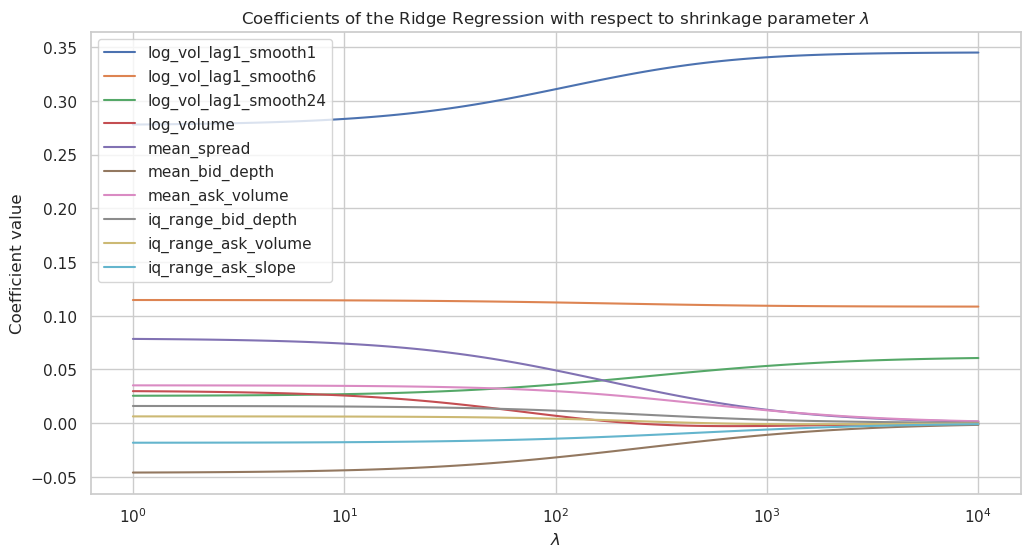

In [17]:
# plot the coefficients with respect to lambda
plt.figure(figsize=(12, 6))
plt.plot(lambdas, coefs, label=coefs.columns)
plt.xscale("log")
plt.title(r"Coefficients of the Ridge Regression with respect to shrinkage parameter $\lambda$")
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficient value")
plt.legend(loc='upper left')
# plt.grid()
plt.show()


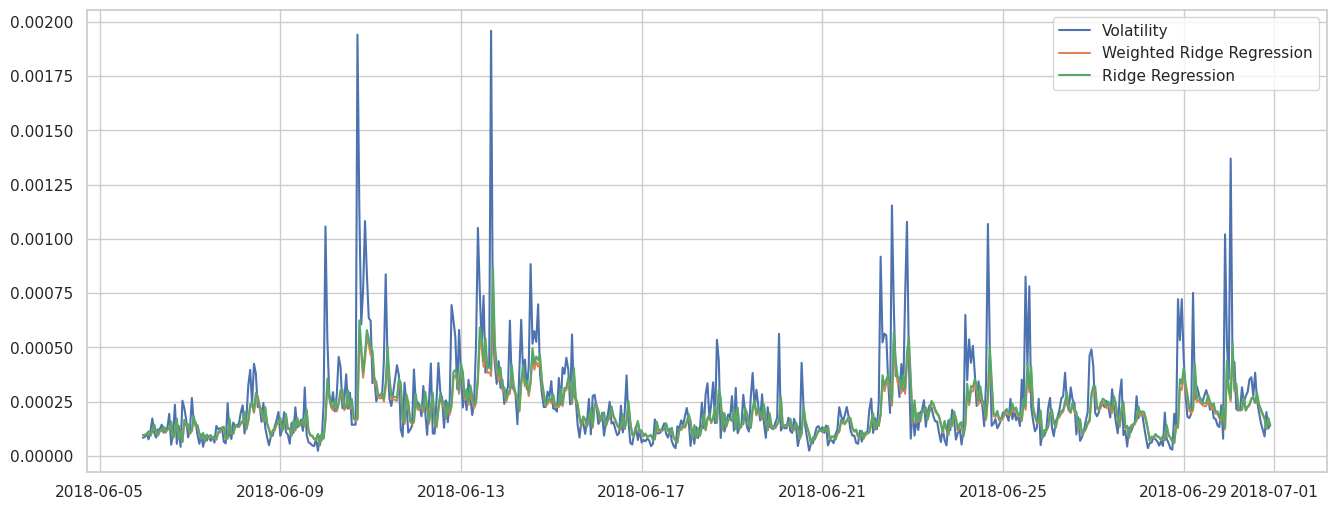

In [18]:
betaW = np.linalg.inv(X.values.T @ (W @ X.values) + 10.0 * LambdaMat) @ (X.values.T @ (W @ y.values))
beta = np.linalg.inv(X.values.T @ (X.values) + 10.0 * LambdaMat) @ (X.values.T @ ( y.values))
plt.plot(y.index, np.exp(y), label='Volatility')
plt.plot(y.index, np.exp(X.values @ betaW), label='Weighted Ridge Regression')
plt.plot(y.index, np.exp(X.values @ beta), label='Ridge Regression')
plt.legend()


We expect $\lambda$ between 0 to 1000 to be optimal, with the most likely value to be order of 10 to 100. 

In [19]:
from vol_predict.models.abstract_benchmark import AbstractBenchmark
# from scipy.optimize import least_squares
# from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


class HARX(AbstractBenchmark):
    """
    """
    def __init__(
        self,
        lags: list = [1, 6, 24], # lags for HAR model
        l2: float = 10.0, # shrinkage parameter, l2 regularization parameter
        is_weighted: bool = False, # whether to weight points by the inverse of the vola
        use_ob_feats: bool = False,
        use_log_y: bool = True,
        *args,
        **kwargs,
    ):
        self.lags = lags
        self.l2 = l2
        self.is_weighted = is_weighted
        self.use_ob_feats = use_ob_feats
        self.use_log_y = use_log_y
        self.label_name = 'log_vol' if use_log_y else 'vol'
        self.name = "HARX" if use_ob_feats else "HAR"
        
        if self.use_log_y:
            self.ma_features = [f'log_vol_lag1_smooth{lag}' for lag in self.lags]
        else:
            self.ma_features = [f'vol_lag1_smooth{lag}' for lag in self.lags]

        if use_ob_feats:
            self.ob_features = [
                                'log_volume',
                                'mean_spread',
                                'mean_bid_depth',
                                'mean_ask_volume',
                                "iq_range_bid_depth",
                                "iq_range_ask_volume",
                                "iq_range_ask_slope",
                                  ]
                                #  'mean_spread',
                                # 'mean_bid_depth',
                                # 'mean_ask_volume',
                                # 'mean_bid_volume',
                                # 'mean_weighted_spread',
                                # 'mean_ask_slope',
                                # 'mean_bid_slope',
                                # 'iq_range_spread',
                                # 'iq_range_bid_depth',
                                # 'iq_range_ask_volume',
                                # 'iq_range_bid_volume',
                                # 'iq_range_weighted_spread',
                                # 'iq_range_ask_slope',
                                # 'iq_range_bid_slope',
                                # ]
            self.feature_names = self.ma_features + self.ob_features
        else:
            self.ob_features = []
            self.feature_names = self.ma_features
        
        self.results = None

    def fit(self, y: pd.Series, X: pd.DataFrame):
        """
        """

        X = X.loc[:, self.feature_names]
        
        self.scaler = StandardScaler()
        X = self.scaler.fit_transform(X)

        X = sm.add_constant(X, has_constant='skip') 

        if self.is_weighted:
            if self.use_log_y:
                weights = 1 / (0.0012 + np.exp(y.values))
            else:
                weights = 1 / (0.0012 + y.values)
        else:
            weights = np.ones(y.shape[0])

        # scale by sample size to make shrinkage uniform across different sample sizes
        normalized_weights = y.values.shape[0] * (weights / (weights.sum()))
        W = np.diag(normalized_weights)

        LambdaMat = self.l2 * np.diag([0]*(1+len(self.lags)) + [1]*(len(self.ob_features)))

        self.beta = np.linalg.inv(X.T @ (W @ X) +  LambdaMat) @ (X.T @ (W @ y.values))
        self.results = self.beta


    def forecast(self, steps: int = 1, X: pd.DataFrame = None):
        """
        Forecast the next steps volatility.
        """
        if self.results is None:
            raise ValueError("Model not fitted yet. Please fit the model first.")

        X = X.loc[:, self.feature_names]#.iloc[-1:]  # take the last row for forecasting
        
        X = self.scaler.transform(X)
        
        # for a single observation we need `has_constant='add'`
        X = sm.add_constant(X, has_constant='add') 

        if self.use_log_y:
            return np.array(np.exp(X @ self.beta))
        else:
            return np.array(X @ self.beta)



    def update(self, new_y: pd.Series, new_X: pd.DataFrame):
        """
        Update the model with new data.
        """
        pass # not needed for this model


## Cross-validation: Weighted estimation

In [20]:


kf = KFold(n_splits=5, shuffle=False)

results = []

har = HARX(
    lags=[1, 6, 24],
    l2=10.0,
    is_weighted=True,
    use_ob_feats=True,
    use_log_y=True,
)

for lambda_ in [0.0, 10.0, 100.0, 1000.0, 10000.0]:
    har.l2 = lambda_
    print(f"Fitting HARX model with l2={har.l2}")
    for train_index, test_index in kf.split(init_training_vola):
        train_data = init_training_vola.iloc[train_index]
        test_data = init_training_vola.iloc[test_index]

        y_train = train_data.loc[:, har.label_name]
        X_train = train_data.loc[:, train_data.columns != har.label_name]

        har.fit(y_train, X_train)

        y_test = test_data.loc[:, har.label_name]
        X_test = test_data.loc[:, test_data.columns != har.label_name]

        predictions = np.zeros((len(y_test), 1))
        for i in range(len(y_test)):
            predictions[i] = har.forecast(steps=1, X=X_test.iloc[[i],:]) * np.exp(y_train.var() / 2)  # bias correction

        rmse = mse(np.exp(y_test.values), predictions) ** 0.5
        mae_res = mae(np.exp(y_test.values), predictions)
        
        results.append({
            "rmse": rmse,
            "mae": mae_res,
            "l2": har.l2})

results = pd.DataFrame(results)

Fitting HARX model with l2=0.0
Fitting HARX model with l2=10.0
Fitting HARX model with l2=100.0
Fitting HARX model with l2=1000.0
Fitting HARX model with l2=10000.0


In [21]:
# calculate the mean and std of rmse and mae for each l2 value
results_mean = results.groupby("l2").mean().reset_index().rename(
    columns={"rmse": "rmse_mean", "mae": "mae_mean"}
)
results_std = results.groupby("l2").std().reset_index().rename(
    columns={"rmse": "rmse_std", "mae": "mae_std"}
)
results = results_mean.merge(results_std, on="l2")

# round the values
results = results.round(7)

results

,l2,rmse_mean,mae_mean,rmse_std,mae_std
0,0.0,0.000176,0.000107,0.000042,0.000018
1,10.0,0.000176,0.000106,0.000042,0.000018
2,100.0,0.000176,0.000105,0.000042,0.000019
3,1000.0,0.000175,0.000104,0.000043,0.000019
4,10000.0,0.000176,0.000104,0.000042,0.000019


## Cross-validation: Non-weighted estimation

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

kf = KFold(n_splits=5, shuffle=False)

results = []

har = HARX(
    lags=[1, 6, 24],
    l2=10.0,
    is_weighted=False,    # !!!!!!!!!!!!!!!!!!!!!!!!!
    use_ob_feats=True,
    use_log_y=True,
)

for lambda_ in [0.0, 10.0, 100.0, 1000.0, 10000.0]:
    har.l2 = lambda_
    print(f"Fitting HARX model with l2={har.l2}")
    for train_index, test_index in kf.split(init_training_vola):
        train_data = init_training_vola.iloc[train_index]
        test_data = init_training_vola.iloc[test_index]

        y_train = train_data.loc[:, har.label_name]
        X_train = train_data.loc[:, train_data.columns != har.label_name]

        har.fit(y_train, X_train)

        y_test = test_data.loc[:, har.label_name]
        X_test = test_data.loc[:, test_data.columns != har.label_name]

        predictions = np.zeros((len(y_test), 1))
        for i in range(len(y_test)):
            predictions[i] = har.forecast(steps=1, X=X_test.iloc[[i],:]) * np.exp(y_train.var() / 2)  # bias correction

        rmse = mse(np.exp(y_test.values), predictions) ** 0.5
        mae_res = mae(np.exp(y_test.values), predictions)
        
        results.append({
            "rmse": rmse,
            "mae": mae_res,
            "l2": har.l2})

results = pd.DataFrame(results)

Fitting HARX model with l2=0.0
Fitting HARX model with l2=10.0
Fitting HARX model with l2=100.0
Fitting HARX model with l2=1000.0
Fitting HARX model with l2=10000.0


In [23]:
# calculate the mean and std of rmse and mae for each l2 value
results_mean = results.groupby("l2").mean().reset_index().rename(
    columns={"rmse": "rmse_mean", "mae": "mae_mean"}
)
results_std = results.groupby("l2").std().reset_index().rename(
    columns={"rmse": "rmse_std", "mae": "mae_std"}
)
results = results_mean.merge(results_std, on="l2")

# round the values
results = results.round(7)

results

,l2,rmse_mean,mae_mean,rmse_std,mae_std
0,0.0,0.000178,0.000112,0.000040,0.00002
1,10.0,0.000178,0.000112,0.000040,0.00002
2,100.0,0.000178,0.000111,0.000041,0.00002
3,1000.0,0.000177,0.000109,0.000041,0.00002
4,10000.0,0.000178,0.000109,0.000040,0.00002


## Conclusions

1. The optimal shrinkage is the maximal shrinkage (reminder: moving average volatility variables are not shrunk, only the OB features are shrunk). This means that the optimal regularized HARX is actually HAR. 
2. Weighting seems to improve the performance of HARX slightly if HARX is estimated using low regularization, but the difference not significantly. Using the optimal (maximal) shrinkage, HARX does not benefit from weighting, which is consistent with the findings for HAR.
3. We tested a version of HARX with shrinkage applied to to all coefficients, but its performance was significantly worse than the HARX with shrinkage applied only to the OB features.
4. Additionally, we tested HARX with different choices of the OB features, but the performance was worse, non-significantly different. 
5. We also tested a version without shrinkage of log_volume variable, but it performed worse then the version with shrinkage of log_volume variable.

Thus, we will keep HAR model without shrinkage on moving average volatility variables and without weighting as one model for the univariate benchmarks. We will also keep HARX with smaller amount of shrinkage on the OB features ($\lambda=100$, expert judgement) and we will estimate it using weighting as it seems to improve the performance of less regularized HARX.

# ENet

In [24]:
from vol_predict.models.baselines.benchmarks import ENET

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [25]:
large_ob_features = [
 'mean_spread',
 'mean_bid_depth',
 'mean_ask_volume',
 'mean_bid_volume',
 'mean_weighted_spread',
 'mean_ask_slope',
 'mean_bid_slope',
 'trend_spread',
 'trend_bid_depth',
 'trend_ask_volume',
 'trend_bid_volume',
 'trend_weighted_spread',
 'trend_ask_slope',
 'trend_bid_slope',
 'iq_range_spread',
 'iq_range_bid_depth',
 'iq_range_ask_volume',
 'iq_range_bid_volume',
 'iq_range_weighted_spread',
 'iq_range_ask_slope',
 'iq_range_bid_slope',
]

NUM_LAGS = 10

dataset = full_data.loc[:, 
                        # RESPONSE
                          #['vol', 'ret', 'log_vol'] +
                           ['log_vol']   +
                        
                        # FEATURES
                          #[f'vol_lag{i}' for i in range(1,NUM_LAGS+1)] +
                          [f'log_vol_lag{i}' for i in range(1,NUM_LAGS+1)] +
                        #   [f'log_vol_lag1_smooth{lag}' for lag in LAGS] +
                          ['log_volume'] +
                          large_ob_features
                          ].dropna()


LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
init_training_vola = dataset.loc[:LAST_TRAINING_DATE]

In [26]:
# params for tuning
alphas = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
param_grid = [(alpha, l1_ratio) for alpha in alphas for l1_ratio in l1_ratios]

feats = [f'log_vol_lag{i}' for i in range(1,10)] + ['log_volume'] + large_ob_features

results = []

kf = KFold(n_splits=5, shuffle=False)

label_name = 'log_vol'  

for alpha, l1_ratio in tqdm(param_grid, desc="Cross-validating ElasticNet models"):

    model = ENET(alpha=alpha, 
            l1_ratio=l1_ratio, 
            num_vola_lags=10,
            use_ob_feats = True,
            use_log_y = True) 

    for train_index, test_index in kf.split(init_training_vola):
        train_data = init_training_vola.iloc[train_index]
        test_data = init_training_vola.iloc[test_index]

        y_train = train_data.loc[:, label_name]
        X_train = train_data.loc[:, feats]
        model.fit(y_train, X_train)

        y_test = test_data.loc[:, label_name]
        X_test = test_data.loc[:, feats]

        predictions = np.zeros((len(y_test), 1))
        for i in range(len(y_test)):
            predictions[i] = model.forecast(X=X_test.iloc[[i],:]) * np.exp(y_train.var() / 2)  # bias correction

        rmse = mse(np.exp(y_test.values), predictions) ** 0.5
        mae_res = mae(np.exp(y_test.values), predictions)
        
        results.append({
            "rmse": rmse,
            "mae": mae_res,
            "alpha": alpha,
            "l1_ratio": l1_ratio})

results = pd.DataFrame(results)

Cross-validating ElasticNet models: 100%|██████████| 48/48 [02:11<00:00,  2.74s/it]


In [27]:
results_copy = results.copy()

In [28]:
results_mean = results.groupby(["alpha", "l1_ratio"]).mean().reset_index().rename(
    columns={"rmse": "rmse_mean", "mae": "mae_mean"}
)
results_std = results.groupby(["alpha", "l1_ratio"]).std().reset_index().rename(
    columns={"rmse": "rmse_std", "mae": "mae_std"}
)
results = results_mean.merge(results_std, on=["alpha", "l1_ratio"])

In [29]:
# round the values
results = results.round(7)

results

,alpha,l1_ratio,rmse_mean,mae_mean,rmse_std,mae_std
0,0.01,0.10,0.000178,0.000117,0.000062,0.000023
1,0.01,0.30,0.000177,0.000115,0.000063,0.000024
2,0.01,0.50,0.000175,0.000113,0.000064,0.000025
3,0.01,0.70,0.000175,0.000113,0.000064,0.000025
4,0.01,0.90,0.000174,0.000112,0.000064,0.000026
5,0.01,0.95,0.000174,0.000112,0.000064,0.000026
6,0.01,0.99,0.000174,0.000112,0.000064,0.000026
7,0.01,1.00,0.000174,0.000112,0.000064,0.000026
8,0.10,0.10,0.000173,0.000111,0.000065,0.000026
9,0.10,0.30,0.000173,0.000110,0.000067,0.000025


## Conclusions

1. Stddev of metrics for all models is higher then for the HARX model. This indicates that the ENet model is more likely to be overfitting this dataset, and our choice of hyperparameters should be more conservative (larger regularization).
2. The best models in terms of both RMSE and MAE are the ones with low regularization (0.01, 0.1) and high l1_ratio. The best model is the one with `alpha=0.1` and `l1_ratio=0.7`.
3. Adding trend features does not improve the performance of ENet.

# RF

In [30]:
from vol_predict.models.baselines.benchmarks import RF

In [31]:
# params for tuning
n_estimators = [100, 200, 500]
max_depth = [3, 5, 10, 20, 50]
min_samples_split = [2, 5, 10]

param_grid = [(n, d, m) for n in n_estimators for d in max_depth for m in min_samples_split]

feats = [f'log_vol_lag{i}' for i in range(1,10)] + ['log_volume'] + large_ob_features

results = []

kf = KFold(n_splits=5, shuffle=False)

label_name = 'log_vol'  

for n_estimators, max_depth, min_samples_split in tqdm(param_grid, desc="Cross-validating RandomForestRegressor models"):

    model = RF(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split, 
            num_vola_lags=10,
            use_ob_feats = True,
            use_log_y = True) 

    for train_index, test_index in kf.split(init_training_vola):
        train_data = init_training_vola.iloc[train_index]
        test_data = init_training_vola.iloc[test_index]

        y_train = train_data.loc[:, label_name]
        X_train = train_data.loc[:, feats]
        model.fit(y_train, X_train)

        y_test = test_data.loc[:, label_name]
        X_test = test_data.loc[:, feats]

        predictions = np.zeros((len(y_test), 1))
        for i in range(len(y_test)):
            predictions[i] = model.forecast(X=X_test.iloc[[i],:]) * np.exp(y_train.var() / 2)  # bias correction

        rmse = mse(np.exp(y_test.values), predictions) ** 0.5
        mae_res = mae(np.exp(y_test.values), predictions)
        
        results.append({
            "rmse": rmse,
            "mae": mae_res,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split})

results = pd.DataFrame(results)

Cross-validating RandomForestRegressor models: 100%|██████████| 45/45 [13:51<00:00, 18.48s/it]


In [32]:
results_copy = results.copy()

In [33]:
results_mean = results.groupby(["n_estimators", "max_depth", "min_samples_split"]).mean().reset_index().rename(
    columns={"rmse": "rmse_mean", "mae": "mae_mean"}
)
results_std = results.groupby(["n_estimators", "max_depth", "min_samples_split"]).std().reset_index().rename(
    columns={"rmse": "rmse_std", "mae": "mae_std"}
)
results = results_mean.merge(results_std, on=["n_estimators", "max_depth", "min_samples_split"])

In [34]:
# round the values
results = results.round(7)

results

,n_estimators,max_depth,min_samples_split,rmse_mean,mae_mean,rmse_std,mae_std
0,100,3,2,0.000183,0.000117,0.000059,0.000021
1,100,3,5,0.000182,0.000116,0.000061,0.000022
2,100,3,10,0.000180,0.000114,0.000062,0.000022
3,100,5,2,0.000184,0.000121,0.000057,0.000022
4,100,5,5,0.000185,0.000121,0.000056,0.000022
5,100,5,10,0.000182,0.000119,0.000058,0.000021
6,100,10,2,0.000184,0.000122,0.000053,0.000019
7,100,10,5,0.000182,0.000121,0.000057,0.000022
8,100,10,10,0.000181,0.000119,0.000059,0.000022
9,100,20,2,0.000183,0.000121,0.000057,0.000021


## Conclusions

1. As in ElasticNet, the dispersion of performance metrics is higher than in HARX, indicating that the model is more likely to be overfitting this dataset. This is expected as we are working with extremely small sample size. Actually, the only reason we are using RF and XGBM is to complete the reproduction of the paper, which used these baselines but had a bigger dataset at hands.
2. The best model in terms of both RMSE and MAE is the one with `n_estimators=200`, `max_depth=3`, and `min_samples_split=2`, but for the sake of being conservative we will chose `n_estimators=200`, `max_depth=3`, and `min_samples_split=10` The performance of the model is (non-significantly) worse than the performance of HARX.

# XGBM

In [35]:
from vol_predict.models.baselines.benchmarks import XGBM

In [36]:
# params for tuning
n_estimators = [50, 100, 200, 500]
max_depth = [3, 5, 10, 20, 50]
min_samples_split = [5, 10, 20]

param_grid = [(n, d, m) for n in n_estimators for d in max_depth for m in min_samples_split]

feats = [f'log_vol_lag{i}' for i in range(1,10)] + ['log_volume'] + large_ob_features

results = []

kf = KFold(n_splits=5, shuffle=False)

label_name = 'log_vol'  

for n_estimators, max_depth, min_samples_split in tqdm(param_grid, desc="Cross-validating RandomForestRegressor models"):

    model = RF(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split, 
            num_vola_lags=10,
            use_ob_feats = True,
            use_log_y = True) 

    for train_index, test_index in kf.split(init_training_vola):
        train_data = init_training_vola.iloc[train_index]
        test_data = init_training_vola.iloc[test_index]

        y_train = train_data.loc[:, label_name]
        X_train = train_data.loc[:, feats]
        model.fit(y_train, X_train)

        y_test = test_data.loc[:, label_name]
        X_test = test_data.loc[:, feats]

        predictions = np.zeros((len(y_test), 1))
        for i in range(len(y_test)):
            predictions[i] = model.forecast(X=X_test.iloc[[i],:]) * np.exp(y_train.var() / 2)  # bias correction

        rmse = mse(np.exp(y_test.values), predictions) ** 0.5
        mae_res = mae(np.exp(y_test.values), predictions)
        
        results.append({
            "rmse": rmse,
            "mae": mae_res,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split})

results = pd.DataFrame(results)

Cross-validating RandomForestRegressor models: 100%|██████████| 60/60 [16:19<00:00, 16.32s/it]


In [37]:
results_copy = results.copy()

In [38]:
results_mean = results.groupby(["n_estimators", "max_depth", "min_samples_split"]).mean().reset_index().rename(
    columns={"rmse": "rmse_mean", "mae": "mae_mean"}
)
results_std = results.groupby(["n_estimators", "max_depth", "min_samples_split"]).std().reset_index().rename(
    columns={"rmse": "rmse_std", "mae": "mae_std"}
)
results = results_mean.merge(results_std, on=["n_estimators", "max_depth", "min_samples_split"])

In [39]:
# round the values
results = results.round(7)

results

,n_estimators,max_depth,min_samples_split,rmse_mean,mae_mean,rmse_std,mae_std
0,50,3,5,0.000179,0.000113,0.000062,0.000023
1,50,3,10,0.000184,0.000118,0.000060,0.000022
2,50,3,20,0.000180,0.000114,0.000064,0.000025
3,50,5,5,0.000182,0.000118,0.000061,0.000023
4,50,5,10,0.000184,0.000119,0.000059,0.000020
5,50,5,20,0.000182,0.000118,0.000060,0.000022
6,50,10,5,0.000183,0.000120,0.000058,0.000021
7,50,10,10,0.000184,0.000120,0.000054,0.000020
8,50,10,20,0.000187,0.000123,0.000055,0.000023
9,50,20,5,0.000182,0.000122,0.000056,0.000023


## Conclusions

1. We will pick the model with `n_estimators=50`, `max_depth=3`, and `min_samples_split=20`.